## Testing trained models on various images:
  * load in saved hats,glasses, and beard models 
  * test each model on the same single image and compare image results 
      * try on all pics, randomly select a one from data/pics
      * try how it works on noncropped images
         * require cropping to better recognize beard, glasses, and hats
  * add facial cropping:  
      - [facial recognizition software](https://github.com/ageitgey/face_recognition)


---
#### This cell is required in order to use GPU for running the model 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras
keras.backend.get_session().run(tf.global_variables_initializer())  

Using TensorFlow backend.
W0906 16:00:21.391955 140178552268608 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0906 16:00:21.392905 140178552268608 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



In [2]:
import face_recognition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras_preprocessing.image import load_img, img_to_array
from keras.models import model_from_json
from keras.applications.resnet50 import preprocess_input as rs50
import os
import sys
from PIL import Image as pil_image

In [3]:
%load_ext autoreload
%autoreload 1

sys.path.append("../python_files/")

import vgg16_preprocess


%aimport vgg16_preprocess

In [4]:
def cropping(file_path):
    '''
    file_path: file_path for the image

    return cropped image of face
    '''
    # load image
    image = face_recognition.load_image_file(file_path)
    face_locations = face_recognition.face_locations(image)
    # list of images with tuples, 4 points
    # (ymin,xmax,ymax,xmin)
    faces = []
    for loc in face_locations:
        delta_y = loc[2] - loc[0]
        delta_x = loc[1] - loc[3]
        y_width = 2.5*delta_y  # experimented to find a good width for hats and beard
        x_increase = int((y_width*0.7 - delta_x)/2)
        y_increase = 1.25*delta_y/2
        # make sure not to go out of range
        y_min = loc[0]-int(y_increase)
        y_max = loc[2]+int(y_increase*0.4)
        x_min = loc[3]-x_increase
        x_max = loc[1]+x_increase
        if x_min < 0:
            x_min = 0
        if x_max > image.shape[1]:
            x_max = image.shape[1]
        if y_min < 0:
            y_min = 0
        if y_max > image.shape[0]:
            y_max = image.shape[0]
        faces.append(image[y_min:y_max,x_min:x_max, :])
    return faces

In [4]:
def test_cropper(filepath):
    '''
    inputs:
    filepath: path to file with images 
    returns:
    show croppper results 
    '''
    files = os.listdir(filepath)
    for file in files:
        if file != '.DS_Store':
        # get face locations 
            faces = cropping(os.path.join(filepath,file))
            if not faces:
                print(f'no faces in {file}')
                continue
            for face in faces:
                # remove identified false faces 
                if face.shape[0] <= 150 or face.shape[1] <= 150:
                    continue
                plt.imshow(face)
                plt.show()

---
#### Import pretrained models: 

In [5]:
def load_pretrained_models(model_path,weight_path):
    '''
    inputs:
    model_path: json model path for resnet50 or vgg16
    weight_path: path to saved best weights as h5 
    returns:
    saved models
    '''
    # load json and create model
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load model weight 
    loaded_model.load_weights(weight_path)
    return loaded_model

#### Load all three models

In [6]:
model_path_vgg16 = '../tuning_data/VGG_16_tuning/vgg_model.json'
file_path = '../tuning_data/VGG_16_tuning/'
eye_wear = file_path+'best_vgg16_model_eyewear.h5'
hat = file_path+'best_vgg16_model_hat.h5'
beard = file_path+'best_vgg16_model_beard.h5'
vgg_glasses = load_pretrained_models(model_path_vgg16,eye_wear)
vgg_hat = load_pretrained_models(model_path_vgg16,hat)
vgg_beard = load_pretrained_models(model_path_vgg16,beard)  # 0 and 1 flipped as the old one (0 is positive)

W0906 16:00:41.649171 140178552268608 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0906 16:00:41.658576 140178552268608 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0906 16:00:41.668135 140178552268608 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0906 16:00:41.673160 140178552268608 deprecation.py:506] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be rem

In [7]:
model_path_resnet = '../tuning_data/resnet_data/resnet50_model_5_up.json'
file_path = '../tuning_data/resnet_data/untracked_resnet50/'
eye_wear = file_path+'best_resnet50_model_eyewear.h5'
hat = file_path+'best_resnet50_model_hat.h5'
beard = file_path+'best_resnet50_model_beard.h5'
resnet_glasses = load_pretrained_models(model_path_resnet,eye_wear)
resnet_hat = load_pretrained_models(model_path_resnet,hat)
resnet_beard = load_pretrained_models(model_path_resnet,beard)

W0906 16:00:48.985430 140178552268608 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2041: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



#### WARNINGS: in all three cases, 0 means yes and 1 means no 

### Checking images:

#### convert jpg image into np.array as data input

In [8]:
def test_image(filepath):
    '''
    inputs:
    filepath: path to file with images 
    returns:
    combined prediction for glasses, beard, and hat 
    '''
    files = os.listdir(filepath)
    glasses = 0  # num glasses 
    beard = 0  # num beard 
    hat = 0  # num hat 
    total = 0 # count total pics used 
    for file in files:
        if file != '.DS_Store':
        # get face locations 
            faces = cropping(os.path.join(filepath,file))
            if not faces:
                # image recognitiond doesn't work go to zoom out, just skip  
                print(f'no faces in {file}')
                continue
            total += 1
            for face in faces:
                # remove identified false faces, assume the fake faces are less than 150 pixel
                if face.shape[0] <=150 or face.shape[1] <= 150:
                    continue
                # show actual image will comment out later 
                plt.imshow(face)
                plt.show()
                # get predicted value for both resnet50 and vgg16
                # vgg16 predictions:
                img_v = pil_image.fromarray(face).resize((150,150),pil_image.NEAREST)
                img_v = np.expand_dims(img_v,axis=0)
                img_v = vgg16_preprocess.preprocess_input(img_v)
                img_v=img_v/255
                # glasses, beard, hat
                preds_v = []
                # make sure beard is index 1
                for model in [vgg_glasses,vgg_beard,vgg_hat]:
                    pred_v= model.predict(img_v)[0][0]
                    preds_v.append(pred_v)
                # resnet50 predictions
                img_r = pil_image.fromarray(face).resize((224,224),pil_image.NEAREST)
                img_r = np.expand_dims(img_r,axis=0)
                img_r = rs50(img_r)
                # glasses, beard, hat
                preds_r = []
                for model in [resnet_glasses,resnet_beard,resnet_hat]:
                    pred_r = model.predict(img_r)[0][0]
                    preds_r.append(pred_r)
                # average the two value 
                pred_c = np.array([preds_v, preds_r]).mean(axis=0)
                if pred_c[0] >= 0.5:
                    glasses += 1 
                if pred_c[1] >= 0.5:
                    beard += 1 
                if pred_c[2] >= 0.5:
                    hat += 1 
    # recommend products:
    index = np.argmax([glasses/total, beard/total, hat/total])
    products = ['eyewear','beard','hat']
    print(f"highly recommend {products[index]} products to this IG user!")
              

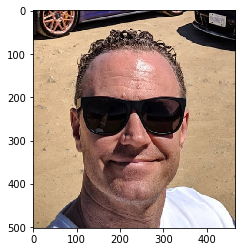

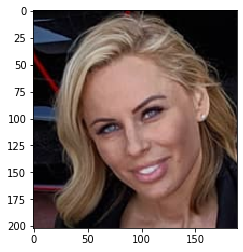

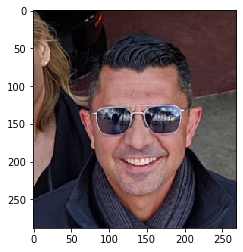

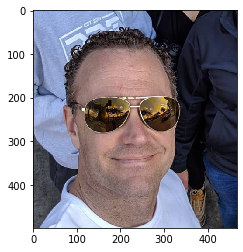

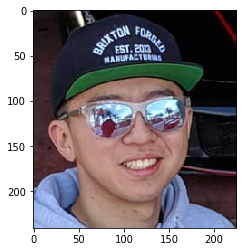

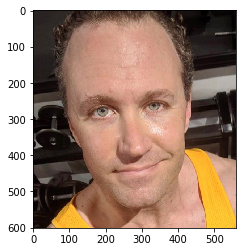

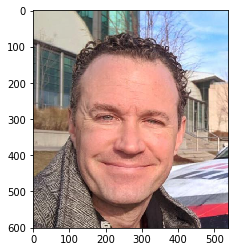

no faces in 19.png


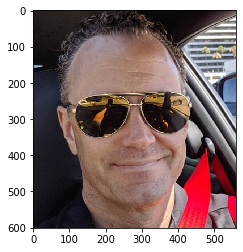

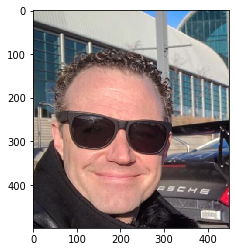

no faces in 10.png


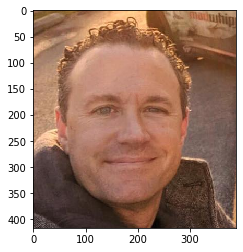

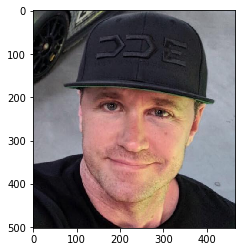

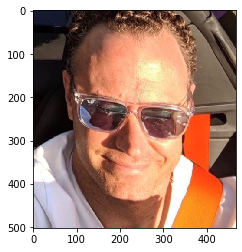

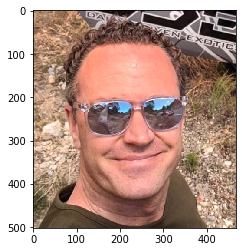

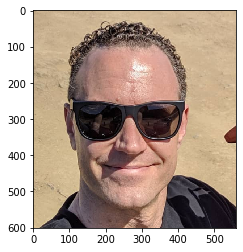

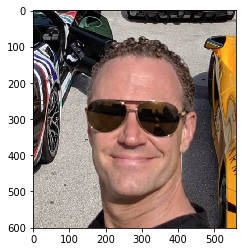

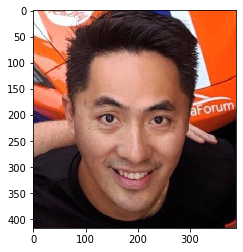

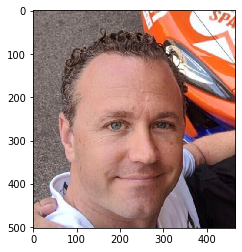

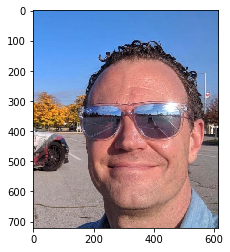

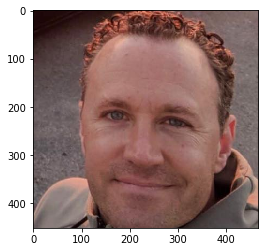

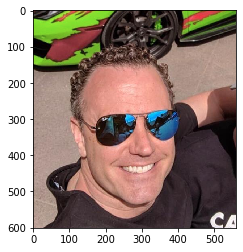

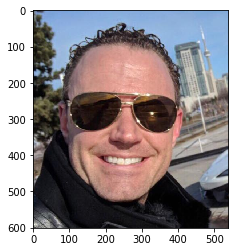

highly recommend eyewear products to this IG user!


In [11]:
test_image('../data/IG_photo/wolf_millionaire')